# Policy Control - DAAF: Regret

In this notebook we analyse the regret for each method proposed to solve policy control when rewards are delayed, aggregate and anonymous.

To measure regret, we use a policy learned with full reward information each time step.

The measure of comparison is the average return over all episodes at the final episode $K_{max}$, $G_{avg,K_{max}} = \frac{1}{K_{max}}\sum^{K_{max}}_{K=1} G_{k}$.

Thus regret is $\frac{G^{m}_{avg,K_{max}} - G^{FR}_{avg,K_{max}}}{G^{FR}_{avg,K_{max}}}$.
It tells us the percentage difference in average return between the policy trained with algorithm $m$ compared to the full rewards policy.
Lower is better.

Key on methods:
  - OP/OT - options policy operating on an options trajectory - i.e. parent trajectory, where the option start matches the reward window period, and the end matchs as well
  - PP/IMR - primitive actions policy, where missing rewards are replaced with a zero (Impute Missing Rewards)
  - PP/LSQ - primitive actions policy, where rewards are recovered; before recovery, the behavior is the same as PP/IMR
  - PP/nTD-SU - primitive actions policy, on n-step TD, where only $t-nstep$ gets updated, considering $t$ is a step with observed aggregate feedback

In [1]:
import copy
import importlib
import os
import pathlib
from typing import Any, Mapping, Sequence

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import ray
import scipy
import seaborn as sns
import tensorflow as tf
from daaf import estimator_metrics
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats import proportion

2024-03-21 23:26:06.892711: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 23:26:06.993111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 23:26:06.994829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 23:26:09.330377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from utils import dataproc

In [4]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/daaf/exp/controljob/agg/1710783127/1710948969/metrics/*.parquet")


In [5]:
df_metrics = dataproc.read_data(files)

/home/guilherme/.pyenv/versions/3.8.15/envs/rl_daaf_py38/lib/python3.8/site-packages/ray/data/datasource/parquet_datasource.py:242: FutureWarning: Passing 'use_legacy_dataset' is deprecated as of pyarrow 15.0.0 and will be removed in a future version.
  pq_ds = pq.ParquetDataset(


Metadata Fetch Progress 0:   0%|          | 0/37 [00:00<?, ?it/s]

2024-03-21 23:26:15,880	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Parquet Files Sample 0:   0%|          | 0/2 [00:00<?, ?it/s]

(_execute_read_task_split pid=3335917) /home/guilherme/.pyenv/versions/3.8.15/envs/rl_daaf_py38/lib/python3.8/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
(_execute_read_task_split pid=3335917)   return transform_pyarrow.concat(tables)


Read progress 0:   0%|          | 0/187 [00:00<?, ?it/s]

/home/guilherme/.pyenv/versions/3.8.15/envs/rl_daaf_py38/lib/python3.8/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)


In [6]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,2020,1710783127-0c58e762-FrozenLake-v1,"{'algorithm': 'sarsa', 'algorithm_args': '{}',...","[0.6902523503216229, 0.6843146956952004, 0.658...","{'returns': {'mean': 0.6277585353785256, 'std'...",PP/IMR
1,2020,1710783127-0c4abb49-ABCSeq,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-8.932211776348343, -9.029688273132113, -8.91...","{'returns': {'mean': -8.972043542800595, 'std'...",PP/LEAST
2,2020,1710783127-0c7d7266-ABCSeq,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-9.040573973280555, -8.904997525977238, -8.89...","{'returns': {'mean': -8.994136566056408, 'std'...",PP/FR
3,2020,1710783127-0c62fb10-ABCSeq,"{'algorithm': 'sarsa', 'algorithm_args': '{}',...","[-99.1578426521524, -100.2350321622959, -100.4...","{'returns': {'mean': -99.71100940128647, 'std'...",OP/OT
4,2020,1710783127-0bf121a4-ABCSeq,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-36.08362196932212, -36.01830776843147, -36.0...","{'returns': {'mean': -36.07530925284512, 'std'...",OP/OT
...,...,...,...,...,...,...
275995,1080,1710783127-fbd9f298-ABCSeq,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-16.896392229417206, -16.861239592969472, -16...","{'returns': {'mean': -16.885522664199815, 'std...",PP/FR
275996,1080,1710783127-e87e1792-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-14.755781683626273, -15.43663274745606, -15....","{'returns': {'mean': -15.024606845513414, 'std...",PP/FR
275997,1080,1710783127-e839088b-TowerOfHanoi,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-37.371877890841816, -35.00185013876041, -35....","{'returns': {'mean': -36.1022664199815, 'std':...",PP/LEAST
275998,1080,1710783127-e8534ab1-TowerOfHanoi,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-34.41258094357077, -35.640148011100834, -37....","{'returns': {'mean': -35.970629047178534, 'std...",PP/LEAST


In [7]:
df_metrics.iloc[0]["meta"]

{'algorithm': 'sarsa',
 'algorithm_args': '{}',
 'discount_factor': 0.99,
 'drop_truncated_feedback_episodes': False,
 'dyna_prog_state_values': array([0.0123561 , 0.01042443, 0.01933841, 0.00947773, 0.01478703,
        0.        , 0.03889444, 0.        , 0.03260246, 0.08433763,
        0.13781085, 0.        , 0.        , 0.17034482, 0.43357944,
        0.        ]),
 'env': {'args': '{"is_slippery": false, "map_name": "4x4"}',
  'level': '4x4',
  'name': 'FrozenLake-v1',
  '_level': 'U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I='},
 'epsilon': 0.2,
 'exp_id': '1710783127-0c58e762-FrozenLake-v1',
 'learning_rate': 0.1,
 'policy_type': 'PP',
 'reward_period': 2,
 'run_id': 10,
 'traj_mapping_method': 'IMR'}

In [8]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,2020,1710783127-0c58e762-FrozenLake-v1,"{'algorithm': 'sarsa', 'algorithm_args': '{}',...","[0.6902523503216229, 0.6843146956952004, 0.658...","{'returns': {'mean': 0.6277585353785256, 'std'...",PP/IMR
1,2020,1710783127-0c4abb49-ABCSeq,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-8.932211776348343, -9.029688273132113, -8.91...","{'returns': {'mean': -8.972043542800595, 'std'...",PP/LEAST
2,2020,1710783127-0c7d7266-ABCSeq,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-9.040573973280555, -8.904997525977238, -8.89...","{'returns': {'mean': -8.994136566056408, 'std'...",PP/FR
3,2020,1710783127-0c62fb10-ABCSeq,"{'algorithm': 'sarsa', 'algorithm_args': '{}',...","[-99.1578426521524, -100.2350321622959, -100.4...","{'returns': {'mean': -99.71100940128647, 'std'...",OP/OT
4,2020,1710783127-0bf121a4-ABCSeq,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-36.08362196932212, -36.01830776843147, -36.0...","{'returns': {'mean': -36.07530925284512, 'std'...",OP/OT
...,...,...,...,...,...,...
275995,1080,1710783127-fbd9f298-ABCSeq,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-16.896392229417206, -16.861239592969472, -16...","{'returns': {'mean': -16.885522664199815, 'std...",PP/FR
275996,1080,1710783127-e87e1792-IceWorld,"{'algorithm': 'q-learning', 'algorithm_args': ...","[-14.755781683626273, -15.43663274745606, -15....","{'returns': {'mean': -15.024606845513414, 'std...",PP/FR
275997,1080,1710783127-e839088b-TowerOfHanoi,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-37.371877890841816, -35.00185013876041, -35....","{'returns': {'mean': -36.1022664199815, 'std':...",PP/LEAST
275998,1080,1710783127-e8534ab1-TowerOfHanoi,"{'algorithm': 'nstep-sarsa', 'algorithm_args':...","[-34.41258094357077, -35.640148011100834, -37....","{'returns': {'mean': -35.970629047178534, 'std...",PP/LEAST


In [9]:
df_wide_metrics = dataproc.wide_metrics(df_metrics)

In [10]:
len(df_wide_metrics["episode"].unique())

250

In [11]:
def get_distinct_envs(df_data: pd.DataFrame):
    envs = {}
    for row in pd.DataFrame(df_data["meta"]).to_dict("records"):
        env = row["meta"]["env"]
        key = (env["name"], env["level"])
        envs[key] = env["args"]
    return envs

In [12]:
envs = dataproc.get_distinct_envs(df_wide_metrics)

In [13]:
envs

{('FrozenLake-v1', '4x4'): '{"is_slippery": false, "map_name": "4x4"}',
 ('ABCSeq', 'n=7'): '{"length": 7, "distance_penalty": false}',
 ('ABCSeq', 'n=10'): '{"length": 10, "distance_penalty": false}',
 ('IceWorld', '4x4'): '{"map_name": "4x4"}',
 ('GridWorld',
  '4x12'): '{"grid": "oooooooooooo\\noooooooooooo\\noooooooooooo\\nsxxxxxxxxxxg"}',
 ('RedGreenSeq',
  'n=9'): '{"cure": ["red", "green", "wait", "green", "red", "red", "green", "wait"]}',
 ('TowerOfHanoi', 'disks=4'): '{"num_disks": 4}',
 ('IceWorld', '8x8'): '{"map_name": "8x8"}'}

## Comparison: Regret - relative to full rewards observation

In [14]:
def calculate_regret_over_configurations(
    df_data, episode: int
):    
    df_result = copy.deepcopy(df_data[df_data["episode"] == episode])
    for key in ("algorithm", "algorithm_args", "reward_period", "discount_factor"):
        df_result[key] = df_result["meta"].apply(lambda meta: meta[key])    
    for key in ("level", "name"):
        df_result[key] = df_result["meta"].apply(lambda meta: meta["env"][key])

    # (env/level)  x (algorithm/algorithm_args) x reward period -> which method is the winner
    df_result["env"] =  df_result["name"] + "/" + df_result["level"]
    del df_result["meta"]    
    del df_result["name"]
    del df_result["level"]
    del df_result["exp_id"]
    
    algo_types = {
        "one-step": set(["sarsa", "q-learning"]),
        "n-step": set(["nstep-sarsa"]),
    }
    def calc_regret(y_pred, y_oracle):
        # agg returns        
        mean_y_oracle = np.mean(y_oracle)
        return np.mean((y_pred - mean_y_oracle) / mean_y_oracle)

    dfs = {} 
    for algo_type, algorithms in algo_types.items():
        df_algo = df_result[df_result["algorithm"].apply(lambda met: met in algorithms)]
        methods = sorted(df_algo["method"].unique())
        rows = []
        keys = ["env", "algorithm", "algorithm_args", "discount_factor", "reward_period"]
        df_baseline = df_algo[df_algo["reward_period"] == 1]
        baselines = {}
        for row in df_baseline.to_dict("records"):
            key = tuple(row[key] for key in keys[:-1])
            baselines[key] = row["returns"]

        df_rp = df_algo[df_algo["reward_period"] != 1]
        rows = []
        for row in df_rp.to_dict("records"):
            key = tuple([row[key] for key in keys[:-1]])
            full_reward_mean_return = baselines[key]
            regret = calc_regret(y_pred=row["returns"], y_oracle = full_reward_mean_return)
            row["relative_regret"] = regret
            row["method"] = row["method"]
            rows.append(row)

        df_regret = pd.DataFrame(rows)
        df_regret = df_regret[["env", "method", "reward_period", "relative_regret"]].sort_values(
            ["env", "method", "reward_period"]
        )
        # drop frozen-lake
        df_regret = df_regret[df_regret["env"].apply(lambda name: "Frozen" not in name)]
        df_regret["relative_regret"] = df_regret["relative_regret"].apply(lambda va: np.log10(va))
        dfs[algo_type] = df_regret
    return dfs

In [15]:
PALETTES = {
    key: color for key, color in zip(sorted(df_metrics["method"].unique()), sns.color_palette())
}

In [16]:
PALETTES

{'OP/OT': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'PP/FR': (1.0, 0.4980392156862745, 0.054901960784313725),
 'PP/IMR': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'PP/LEAST': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'PP/nTD-SU': (0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

In [17]:
def plot_regret(df_data, suffix = None, method_filter_fn=lambda met: True, output_dir="figures/regret"):
    df_raw = df_data[["env", "reward_period", "method", "relative_regret"]]
    df_raw = df_raw[df_raw["method"].apply(method_filter_fn)]    
    rps = df_raw["reward_period"].unique()
    fig, axes = plt.subplots(nrows=1, ncols=len(rps), figsize=(3 * len(rps), 3), sharey=True)
    
    legend_shown = False
    for ax, rp in zip(axes.flatten(), rps):
        df_plot = df_raw[df_raw["reward_period"] == rp]
        sns.boxplot(
            df_plot, 
            x="env", y="relative_regret", 
            hue="method",
            palette=PALETTES,
            ax=ax
        )
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("Environment")
        ax.set_ylabel("Log[relative regret (%)]")
        ax.set_title(f"Reward Period, P = {rp}")
        if legend_shown is False:
            legend_shown = True
            ax.legend(loc='upper center', bbox_to_anchor=(len(rps)/ 2, 1.3), ncol=3, fancybox=True)            
        else:
            ax.legend().set_visible(False)            
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    name = f"regret_{suffix}.pdf"        
    path = os.path.join(output_dir, name)
    plt.savefig(path, dpi=300, format="pdf", bbox_inches = "tight")

In [18]:
def plot_regret_dist(df_data):
    sns.displot(data=df_data, x="relative_regret", col="env", hue="method", kind="kde")

In [19]:
dfs_regret = calculate_regret_over_configurations(df_metrics, episode=df_metrics["episode"].max())

### One-Step

In [20]:
dfs_regret["one-step"]

,env,method,reward_period,relative_regret
2,ABCSeq/n=10,OP/OT,2,0.093297
198,ABCSeq/n=10,OP/OT,2,0.095699
353,ABCSeq/n=10,OP/OT,2,0.109978
375,ABCSeq/n=10,OP/OT,2,0.111242
10,ABCSeq/n=10,OP/OT,4,0.768851
...,...,...,...,...
407,TowerOfHanoi/disks=4,PP/LEAST,8,-1.012115
93,TowerOfHanoi/disks=4,PP/LEAST,16,-0.451545
110,TowerOfHanoi/disks=4,PP/LEAST,16,-0.450706
189,TowerOfHanoi/disks=4,PP/LEAST,16,-0.567590


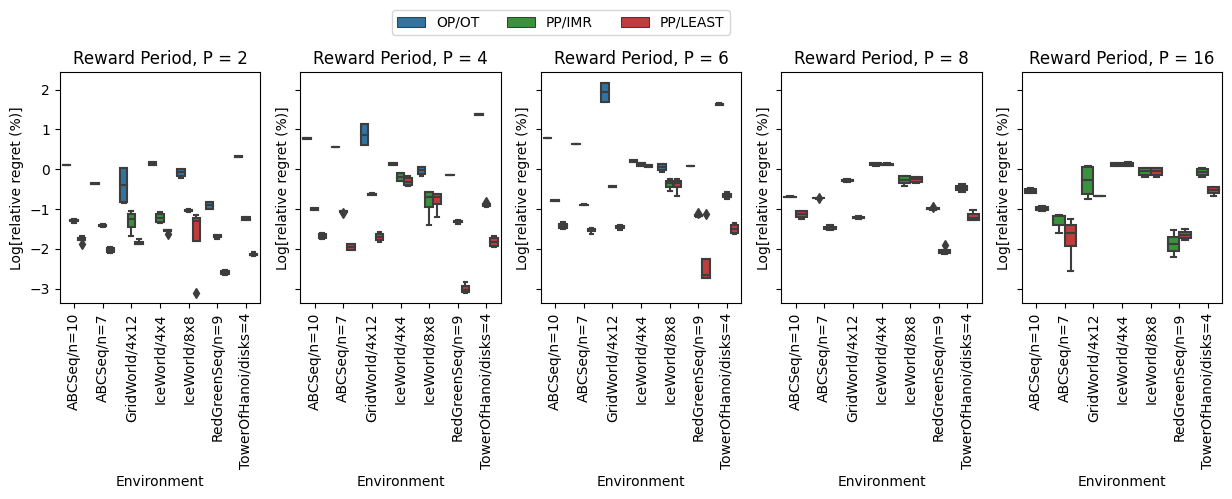

In [21]:
plot_regret(dfs_regret["one-step"], suffix="one-step_all")

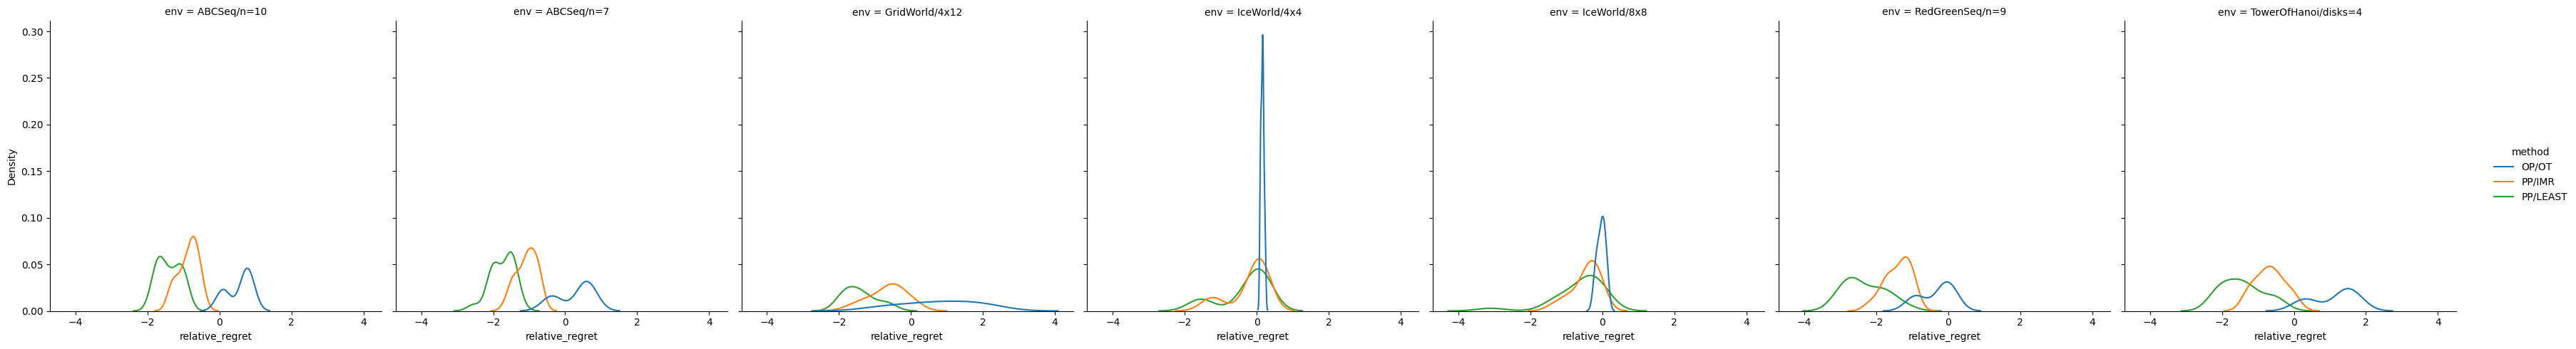

In [22]:
plot_regret_dist(dfs_regret["one-step"])

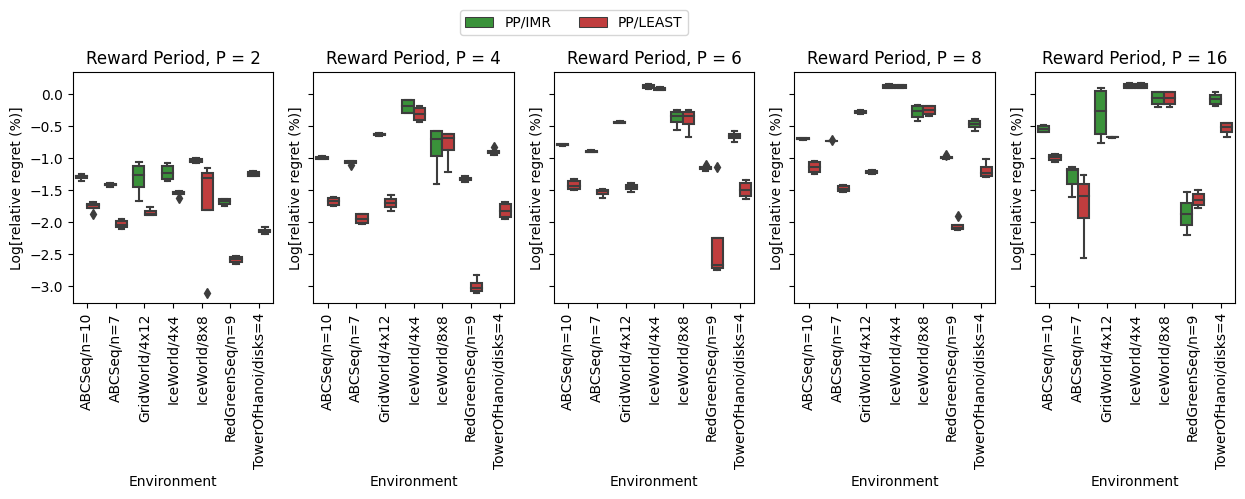

In [23]:
plot_regret(dfs_regret["one-step"], method_filter_fn=lambda x: "OP/OT" not in x, suffix="one-step_nooptions")

### N-step

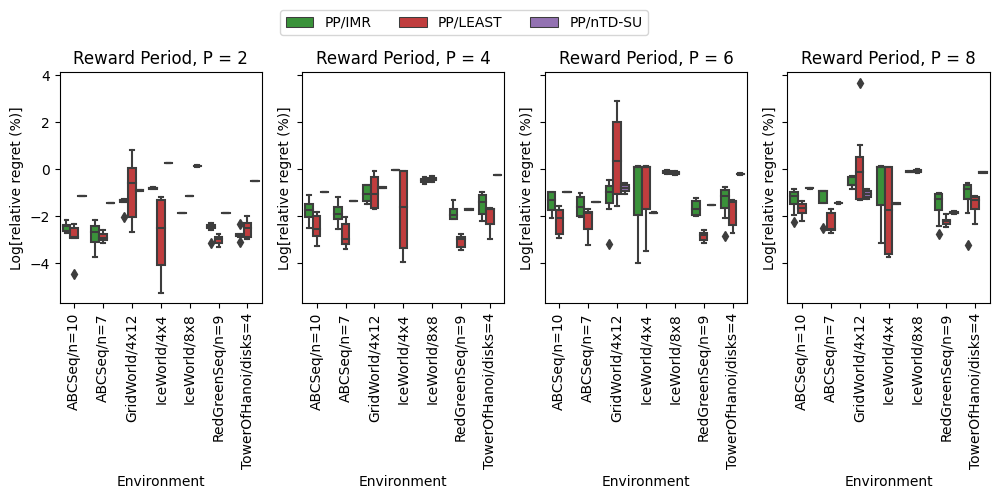

In [24]:
plot_regret(dfs_regret["n-step"], suffix="n-step_all")

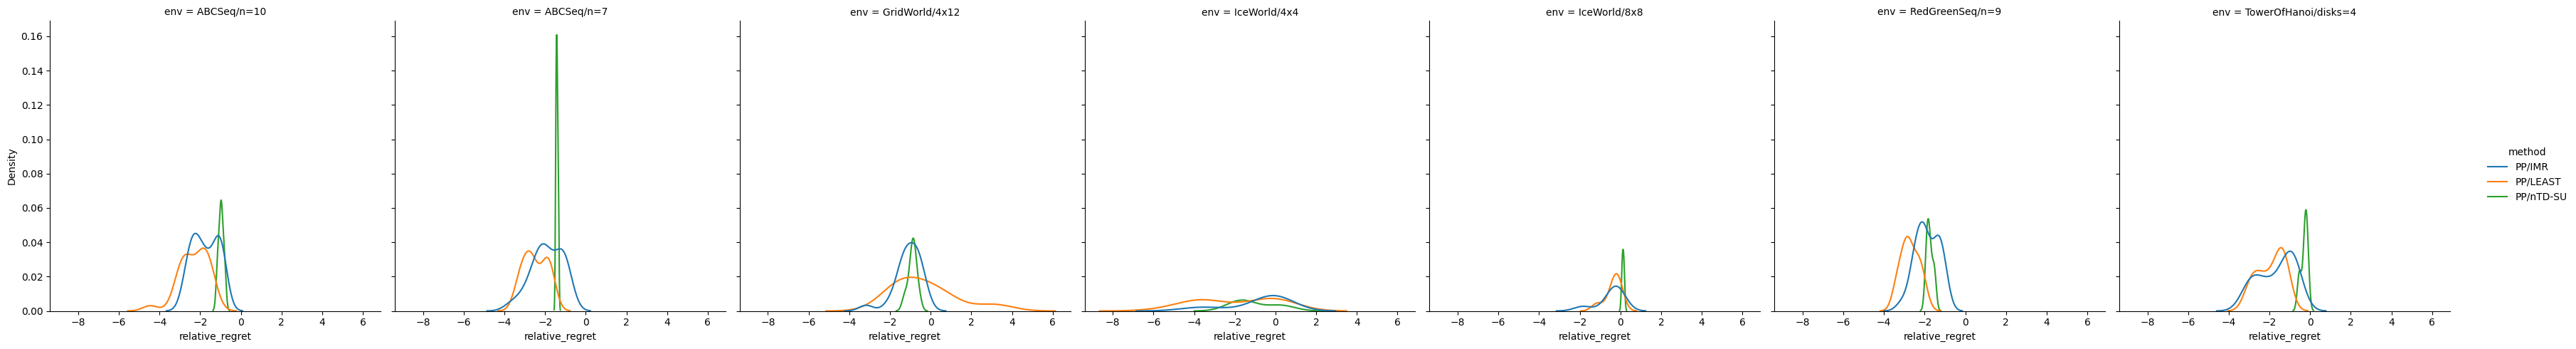

In [25]:
plot_regret_dist(dfs_regret["n-step"])